# Statisitically Testing 2P Responses to Stimulus
In most analyses, some form of *inclusion criteria* is used to select neurons that are "responsive" to the stimulus conditions presented. There are no universally agreed upon inclusion criteria for this type of selection. In [{cite}`Mesa2021`](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8114876/), it is demonstrated that the choice of inclusion criteria can dramatically affect what neurons are selected as responsive. This notebook does a similar demonstration, using the same five inclusion criteria on Ophys DFF recordings to select responsive neurons from one experimental session. It can be seen that very different selections are made depending on the criteria used. This also underscores how different critera might be more or less appropriate for the type of stimulus and the type of measurements being used for analysis. For more information about DFF, see [Visualizing 2P Responses to Stimulus](../visualization/visualize_2p_responses.ipynb).

### Environment Setup

In [776]:
### if running on Google Colab, run this cell once, then restart the runtime and run the rest of the notebook
import os
if "COLAB_GPU" in os.environ:
    !wget https://raw.githubusercontent.com/AllenInstitute/openscope_databook/main/requirements.txt
    %pip install -r requirements.txt --user

In [777]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from dandi import dandiapi
from pynwb import NWBHDF5IO
from scipy import interpolate
from scipy.stats import ttest_ind

%matplotlib inline

### Downloading Ophys File
Change the values below to download the file you’re interested in. Set `dandiset_id` and `dandi_filepath` to correspond to the dandiset id and filepath of the file you want. If you’re accessing an embargoed dataset, change `authenticate` to True, and set `dandi_api_key` to your DANDI API key. If you want to stream a file instead of downloading it, checkout [Streaming an NWB File with fsspec](../basics/stream_nwb.ipynb).

In [778]:
dandiset_id = "000336"
dandi_filepath = "sub_1170622509/sub_1170622509sess_1194683535/sub_1170622509+sess_1194683535+exp_1194752582_ophys.nwb"
authenticate = True
dandi_api_key = os.environ["DANDI_API_KEY"]
download_loc = "."

In [779]:
filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}/{filename}"

In [780]:
if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id)
print(f"Got dandiset {my_dandiset}")

Got dandiset DANDI:000336/draft


In [781]:
# file = my_dandiset.get_asset_by_path(dandi_filepath)
# # this may take awhile, especially if the file to download is large
# file.download(filepath)

# print(f"Downloaded file to {filepath}")

### Getting 2P Data and Stimulus Data
Below, the fluorescence traces and timestamps are read from the file's `Processing` section. In this notebook, we will be interested in the DFF trace specifically. Note that the exact format to access these traces can vary between newer and older NWB files, so some adjustments may be necessary. Additionally, the stimulus data is also read from the NWB file's `Intervals` section. Stimulus information is stored as a series of tables depending on the type of stimulus shown in the session. One such table is displayed below, as well as the names of all the tables.

In [782]:
io = NWBHDF5IO(filepath, mode="r", load_namespaces=True)
nwb = io.read() 

c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.5.1 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.6.0-alpha is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.2.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [783]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

flr = nwb.processing["ophys"]["corrected_fluorescence"]
flr_trace = flr.roi_response_series["traces"].data
flr_timestamps = flr.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)


### Selecting Stimulus Times
Different types of stimulus  different kinds of inclusion criteria.

In [784]:
stimulus_names = list(nwb.intervals.keys())
print(stimulus_names)

['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_worms_fwd_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations']


In [891]:
stim_table = nwb.intervals["movie_worms_fwd_presentations"]
print(stim_table.colnames)
stim_table[:100]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'frame', 'color', 'contrast', 'opacity', 'ori', 'size', 'units', 'stimulus_index', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,frame,color,contrast,opacity,ori,size,units,stimulus_index,tags,timeseries
id,,,,,,,,,,,,,,
0,80.066440,80.099801,movie_worms_fwd,5.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3859, 2, timestamps pynwb.base.TimeSeries at..."
1,80.099801,80.133162,movie_worms_fwd,5.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3861, 2, timestamps pynwb.base.TimeSeries at..."
2,80.133162,80.166523,movie_worms_fwd,5.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3863, 2, timestamps pynwb.base.TimeSeries at..."
3,80.166523,80.199884,movie_worms_fwd,5.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3865, 2, timestamps pynwb.base.TimeSeries at..."
4,80.199884,80.233245,movie_worms_fwd,5.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(3867, 2, timestamps pynwb.base.TimeSeries at..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,83.235801,83.269164,movie_worms_fwd,5.0,95.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(4049, 2, timestamps pynwb.base.TimeSeries at..."
96,83.269164,83.302526,movie_worms_fwd,5.0,96.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(4051, 2, timestamps pynwb.base.TimeSeries at..."
97,83.302526,83.335889,movie_worms_fwd,5.0,97.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",pix,2.0,[stimulus_time_interval],"[(4053, 2, timestamps pynwb.base.TimeSeries at..."


In [892]:
len(stim_table)

16200

In [893]:
len(set(stim_table.frame))

270

In [894]:
float(stim_table[269].start_time) - float(stim_table[0].start_time)

8.97409621665777

In [895]:
### select start times from table that fit certain critera here

# stim_select = lambda row: True
stim_select = lambda row: float(row.frame) == 50
all_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if stim_select(stim_table[i])]
len(all_stim_times)

60

### Fluorescence Interpolation

In [896]:
interp_hz = 10

In [897]:
print(dff_trace.shape)
print(dff_timestamps.shape)

(42337, 103)
(42337,)


In [898]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))
interp_dff = []

# interpolate channel by channel to save RAM
for channel in range(dff_trace.shape[1]):
    f = interpolate.interp1d(dff_timestamps, dff_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_dff.append(f(time_axis))

interp_dff = np.array(interp_dff)

print(interp_dff.shape)

(103, 39415)


### Getting Stimulus Time Windows

In [899]:
window_start_time = -2
window_end_time = 4

In [900]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in all_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - dff_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_dff.shape[1]:
        continue
        
    windows.append(interp_dff[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows) * 100 # x100 to convert values to percentage
print(windows.shape)

(60, 103, 60)


### Getting stim window info

In [901]:
# get the index within the window that stimulus occurs (time 0)
stimulus_onset_idx = int(-window_start_time * interp_hz)
baseline = windows[:,:,0:stimulus_onset_idx]
evoked_responses = windows[:,:,stimulus_onset_idx:]

print(stimulus_onset_idx)

20


### Aligning Time Windows

In [919]:
def show_dff_response(dff, window_start_time, window_end_time, figsize=None, aspect="auto", vmin=None, vmax=None, yticks=[], yticklabels=[]):
    if len(dff) == 0:
        print("Input data has length 0; Nothing to display")
        return
    
    fig, ax = plt.subplots(figsize=figsize)
    img = ax.imshow(dff, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(dff)], vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(img, shrink=0.5)

    if len(yticks) != 0:
        ax.set_yticks(range(len(yticklabels)))
    if len(yticklabels) != 0:
        ax.set_yticklabels(yticklabels, fontsize=8)

    ax.plot([0,0],[0, len(dff)], ":", color="white", linewidth=1.0)

(103, 60)


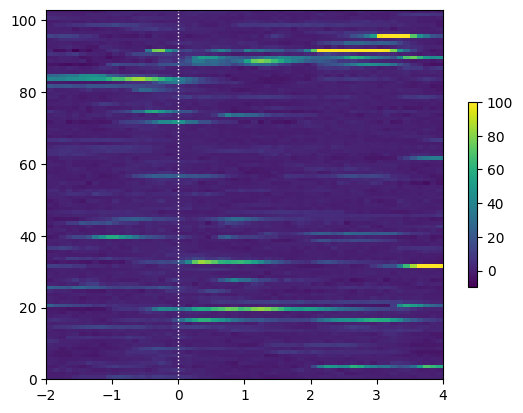

In [920]:
mean_window = np.mean(windows, axis=0)
print(mean_window.shape)
show_dff_response(mean_window, window_start_time, window_end_time, vmax=100)

### Inclusion Criteria 1
maximum value of mean evoked response is >10%
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4731241/

In [921]:
mean_evoked_responses = np.mean(evoked_responses, axis=0)
max_mean_evoked_responses = np.max(mean_evoked_responses, axis=1)
selected_units = np.where(max_mean_evoked_responses > 10)[0]
selected_units

array([ 7,  9, 11, 12, 13, 14, 15, 19, 20, 24, 28, 29, 31, 41, 46, 58, 59,
       62, 63, 64, 69, 70, 71, 75, 78, 81, 82, 83, 86, 88, 99],
      dtype=int64)

31 / 103 units selected


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_8856\1447191435.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels, fontsize=8)


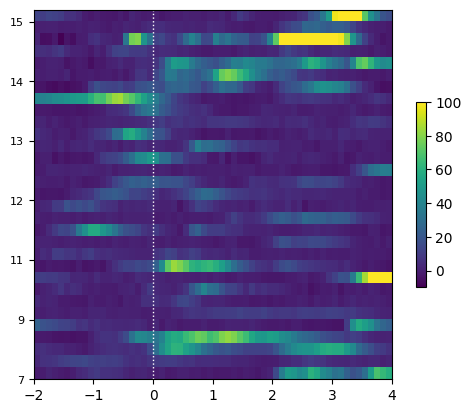

In [922]:
print(f"{len(selected_units)} / {windows.shape[1]} units selected")
show_dff_response(mean_window[selected_units], window_start_time, window_end_time, aspect=0.2, yticklabels=selected_units, vmax=100)

### Inclusion Criteria 2
in 50% of trials, response is A) larger than 3x the SD of baseline, and B) larger than 5% DFF https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6622284/

In [923]:
all_baseline_sds = np.std(baseline, axis=2)
print(all_baseline_sds.shape)

max_responses = np.max(evoked_responses, axis=2)
print(max_responses.shape)

(60, 103)
(60, 103)


In [924]:
# units in each trial that respond more than 3x the SD of baseline
deviant_responses = max_responses > 3*all_baseline_sds
# units in each trial that response more than 5% dff
large_responses = max_responses > 5
# units in each trial that do both of the above
sig_responses = deviant_responses & large_responses

# units that have significant responses in 50% or more trials
half_trials = sig_responses.shape[0] / 2
selected_units = np.where( np.sum(sig_responses, axis=0) > half_trials )[0]
selected_units

array([ 1,  7, 11, 13, 15, 41, 64, 71, 82, 83, 99], dtype=int64)

11 / 103 units selected


C:\Users\carter.peene\AppData\Local\Temp\ipykernel_8856\1447191435.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels, fontsize=8)


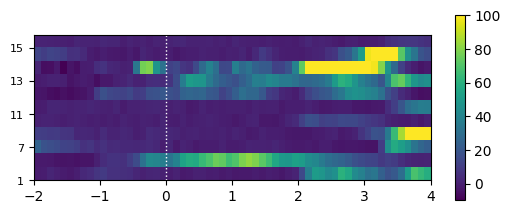

In [925]:
print(f"{len(selected_units)} / {windows.shape[1]} units selected")
show_dff_response(mean_window[selected_units], window_start_time, window_end_time, aspect=0.2, yticklabels=selected_units, vmax=100)

### Inclusion Criteria 3
paired t test (p<0.05) with Bonferroni correction, comparing mean baseline to mean evoked response https://pubmed.ncbi.nlm.nih.gov/22196337/

In [926]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
mean_trial_baselines = np.mean(baseline, axis=2)

n = mean_trial_responses.shape[0]
t,p = ttest_ind(mean_trial_responses, mean_trial_baselines)
selected_units = np.where(p < 0.05 / n)[0]
selected_units

array([ 7,  9, 11, 13, 14, 18, 19, 41, 45, 64, 70, 71, 73, 77, 80, 83, 99],
      dtype=int64)

17 / 103 units selected


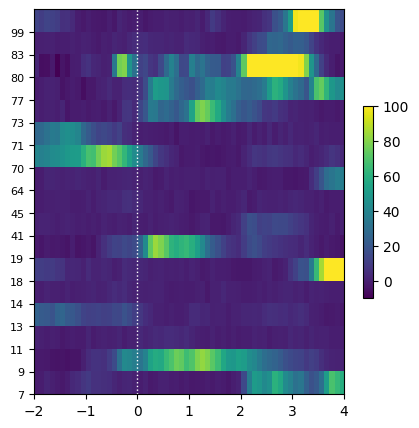

In [927]:
print(f"{len(selected_units)} / {windows.shape[1]} units selected")
show_dff_response(mean_window[selected_units], window_start_time, window_end_time, figsize=(5,5), yticks=selected_units[::5], yticklabels=selected_units, vmax=100)

### Inclusion Criteria 4
A) The mean response (dF/F) to any stimulus condition is is >6% and B) reliability >1 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3248795/

In [928]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
response_means = np.mean(mean_trial_responses, axis=0)
response_sds = np.std(mean_trial_responses, axis=0)

mean_trial_baselines = np.mean(baseline, axis=2)
baseline_means = np.mean(mean_trial_baselines, axis=0)
baseline_sds = np.std(mean_trial_baselines, axis=0)

reliabilities = (response_means - baseline_means) / (response_sds + baseline_sds)

In [929]:
sig_reliabilities = reliabilities > 1
large_responses = response_means > 6
selected_units = np.where(sig_reliabilities & large_responses)[0]

In [930]:
print(f"{len(selected_units)} / {windows.shape[1]} units selected")
show_dff_response(mean_window[selected_units], window_start_time, window_end_time, figsize=(5,5), yticks=selected_units[::5], yticklabels=selected_units)

0 / 103 units selected
Input data has length 0; Nothing to display


### Inclusion Criteria 5
maximum dff to any stimulus condition is >4% https://pubmed.ncbi.nlm.nih.gov/24583013/

In [931]:
max_responses = np.max(evoked_responses, axis=2)
selected_units = np.where( np.any(max_responses > 4, axis=0) )[0]

103 / 103 units selected


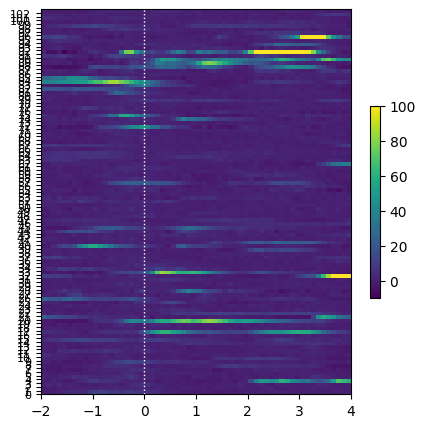

In [932]:
print(f"{len(selected_units)} / {windows.shape[1]} units selected")
show_dff_response(mean_window[selected_units], window_start_time, window_end_time, figsize=(5,5), yticks=selected_units[::5], yticklabels=selected_units, vmax=100)